# Mood Prediction
In this notebook, two experiments are performed, a regression and classification task.

Feature selection is performed by first engineering additional variables and calculating correlation, filtering out redundant variables that lack predictive power and then running the regression task of predicting my mood on a 5 point scale and then a classification task of a good or bad day.

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime as dt
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret.classification as c
import pycaret.regression as r
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_pickle('../data/all.csv')

## Feature Selection
For feature selection I will be calculating the correlation of all variables to Mood. I will set the threshold of 0.5 for what is acceptable as a feature for the ml algorithm

I will perform feature engineering by creating the square of features and their rolling 7 day average.

In [3]:
features = ['Stress', 'Sleepiness', 'CaloriesBurned', 'Steps', 'Distance',
       'Floors', 'SedentaryMinutes', 'LightlyActiveMinutes',
       'FairlyActiveMinutes', 'VeryActiveMinutes', 'ActivityCalories', 'FB_Onset', 'FB_Offset', 'FB_TST', 'FB_WASO',
       'FB_NOA', 'FB_TIB', 'FB_REMSD', 'FB_LSD', 'FB_DSD', 'FB_TSDP', 'FB_AI',
       'FB_SWSP', 'FB_REMP', 'FB_SMI', 'FB_Midpoint', 'FB_SleepRegularity', 'SS_Bedtime', 'SS_SOL', 'SS_TST', 'SS_WASO',
       'SS_Waketime', 'SS_TIB', 'SS_NOA', 'SS_LSD', 'SS_DSD', 'SS_REMSD',
       'SS_ARR', 'SS_SS', 'SS_MS', 'SS_BS', 'SS_SE', 'SS_SMI', 'SS_AI',
       'SS_REMP', 'SS_SWSP', 'SS_Onset', 'SS_Offset', 'SS_TSDP', 'SS_Midpoint',
       'SS_SleepRegularity']

for col in features: 
    df[col + '_sq'] = df[col] ** 2
    df[col + '_cube'] = df[col] ** 3
    df[col + '_R7DM'] = df[col].rolling(7, 1).std()

In [4]:
threshold = 0.25
corr = abs(df.corr()[['Mood_num', 'Mood_bin_num']])
corr = corr[corr > threshold].dropna(how='any')

In [5]:
features = list(corr.index[:-10]) # removing target, square and cube features as they do not add much value

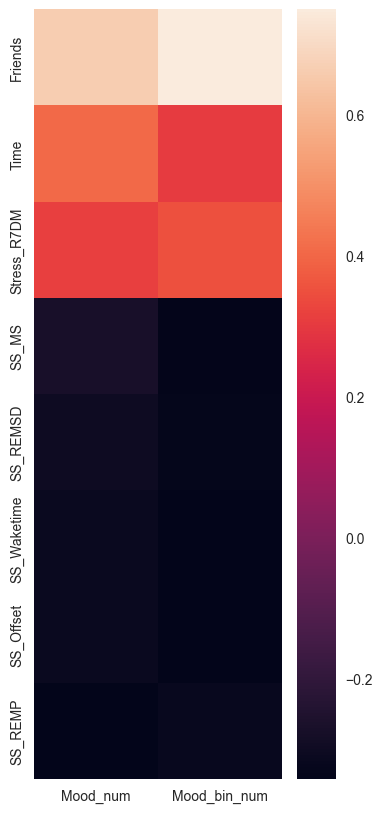

In [6]:
ax, fig = plt.subplots(figsize=(4, 10))
sns.heatmap(df[features].corr()[['Mood_num', 'Mood_bin_num']][2:].sort_values(by='Mood_num', ascending=False));

I don't believe the square and cube features are adding any additional value so they will be dropped

In [7]:
features = list(corr.index[2:-10])
target_reg = ['Mood_num']
target_class = ['Mood_bin_num']

## Model Selection

In [8]:
df = df[features + target_reg + target_class].dropna(thresh=len(features) - 2)
df_reg = df[features + target_reg]
df_class = df[features + target_class]

### Regression Task - Mood_num

In [9]:
df_reg.head()

,Time,Friends,SS_Waketime,SS_REMSD,SS_MS,SS_REMP,SS_Offset,Stress_R7DM,Mood_num
0,16.200000,0,7.529444,89.0,87.0,19.56,7.529444,NaN,2
1,20.750000,0,7.312222,96.0,94.0,20.82,7.312222,0.056569,1
2,18.350000,1,6.980000,106.0,91.0,23.71,6.980000,0.189033,4
3,22.733333,0,6.884722,31.0,53.0,7.54,6.884722,0.157903,4
4,22.150000,0,7.265833,74.0,83.0,19.58,7.265833,0.148593,2


In [10]:
df_reg.Mood_num.value_counts()

3    16
2     9
4     7
1     6
0     4
Name: Mood_num, dtype: int64

In [11]:
reg = r.setup(df_reg, 
                   target = 'Mood_num', 
                   normalize=True, session_id=101)

,Description,Value
0,session_id,101
1,Target,Mood_num
2,Original Data,"(42, 9)"
3,Missing Values,True
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(29, 7)"


In [12]:
best_reg = r.compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.6175,0.6413,0.7193,-0.3508,0.2887,0.2749,0.0050
ridge,Ridge Regression,0.6314,0.6603,0.7296,-0.4178,0.2954,0.2757,0.0050
lr,Linear Regression,0.6429,0.6975,0.7550,-0.4025,0.2946,0.2939,0.5460
huber,Huber Regressor,0.6547,0.6678,0.7297,-0.3729,0.2963,0.3023,0.0060
omp,Orthogonal Matching Pursuit,0.7294,0.7112,0.7711,-0.1623,0.3180,0.2892,0.0050
et,Extra Trees Regressor,0.8313,0.9628,0.9116,-0.6608,0.3689,0.3521,0.0530
rf,Random Forest Regressor,0.8415,0.9574,0.8914,-0.5658,0.3562,0.3701,0.0660
gbr,Gradient Boosting Regressor,0.8469,0.9971,0.9377,-0.7818,0.3671,0.3925,0.0130
ada,AdaBoost Regressor,0.8549,1.0222,0.9551,-0.6598,0.3742,0.3619,0.0280
knn,K Neighbors Regressor,0.9300,1.2860,1.0544,-1.6279,0.4147,0.3972,0.0070


#### Tuning Bayesian Ridge

In [13]:
tuned_reg = r.tune_model(best_reg)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1206,1.3841,1.1765,-1.0762,0.6305,0.6384
1,0.3239,0.1089,0.3300,0.9455,0.1240,0.2247
2,1.2665,1.8810,1.3715,-7.4644,0.3972,0.3651
3,0.3723,0.1559,0.3948,0.2985,0.1307,0.1550
4,0.3812,0.1709,0.4134,0.8078,0.1494,0.2429
5,0.5521,0.6419,0.8012,0.6790,0.4983,0.0485
6,0.5452,0.5239,0.7238,0.4107,0.1744,0.1724
7,0.2339,0.1002,0.3166,0.8497,0.0739,0.0775
8,0.4065,0.4229,0.6503,0.5242,0.2576,0.3852


In [14]:
print(tuned_reg)

BayesianRidge(alpha_1=0.001, alpha_2=0.05, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=0.1, lambda_2=0.3,
              lambda_init=None, n_iter=300, normalize=False, tol=0.001,
              verbose=False)


#### Predicting with Best Regression

In [15]:
r.predict_model(tuned_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.1467,1.8057,1.3438,-0.5412,0.4942,0.4217


,Time,Friends,SS_REMSD,SS_MS,SS_REMP,SS_Offset,Stress_R7DM,Mood_num,Label
0,0.725913,0,0.703714,1.273915,0.402696,-0.350465,-1.757199,1,2.042272
1,-0.514926,0,0.662319,0.809800,0.668416,-0.284582,-1.018452,2,1.390874
2,-0.610009,1,-0.952084,-1.325127,0.574066,0.100761,-1.757199,3,1.441596
3,0.317054,0,-1.324639,-1.696419,-1.285972,1.465815,-0.580580,2,1.315534
4,-0.120330,1,-1.117664,-1.510773,-0.985593,-0.635325,-0.820556,3,2.529239
5,1.291659,0,-1.986958,-2.531826,-2.154375,-1.079915,-0.417036,4,1.200071
6,0.597550,1,-0.289765,-0.304075,-0.419495,-0.324397,-0.123819,4,3.280839
7,0.231479,0,0.289765,0.624154,0.058031,-0.096414,-0.766069,2,1.938436
8,0.150658,0,-0.165580,0.252862,-0.142222,1.284281,-0.459749,0,2.094730
9,-0.472139,0,0.331160,0.160040,0.083062,0.940174,-0.808733,3,1.397503


#### Evaluate Model

In [16]:
path = '../visuals/models/mood_reg'

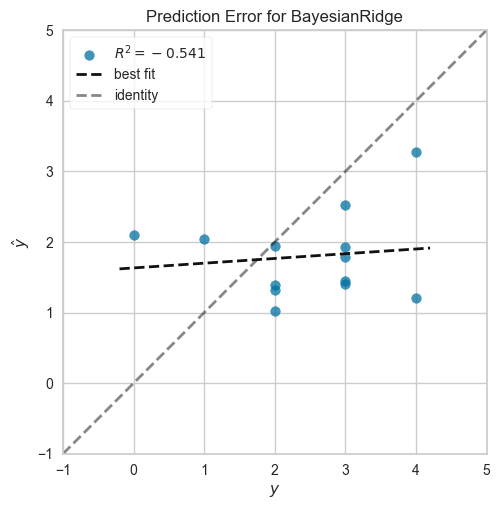

In [17]:
r.plot_model(tuned_reg, plot='error', save=path)
r.plot_model(tuned_reg, plot='error')

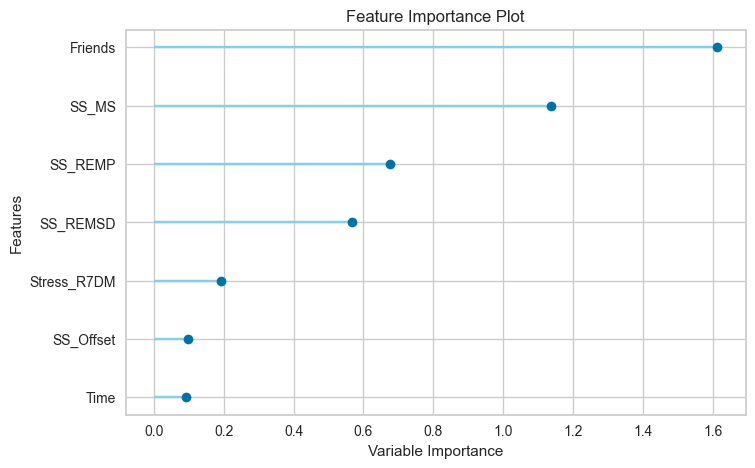

In [18]:
r.plot_model(tuned_reg, plot='feature', save=path)
r.plot_model(tuned_reg, plot='feature')

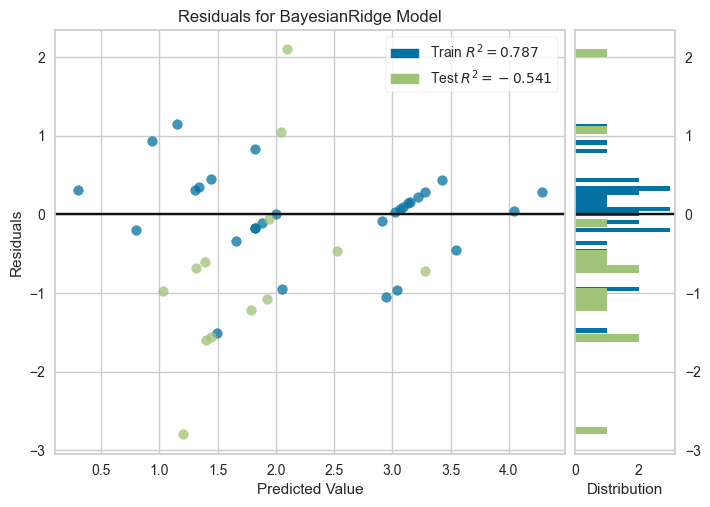

In [19]:
r.plot_model(tuned_reg, plot='residuals', save=path)
r.plot_model(tuned_reg, plot='residuals')

### Classification Task - Mood_bin_num

In [20]:
df_class.head()

,Time,Friends,SS_Waketime,SS_REMSD,SS_MS,SS_REMP,SS_Offset,Stress_R7DM,Mood_bin_num
0,16.200000,0,7.529444,89.0,87.0,19.56,7.529444,NaN,0
1,20.750000,0,7.312222,96.0,94.0,20.82,7.312222,0.056569,0
2,18.350000,1,6.980000,106.0,91.0,23.71,6.980000,0.189033,1
3,22.733333,0,6.884722,31.0,53.0,7.54,6.884722,0.157903,1
4,22.150000,0,7.265833,74.0,83.0,19.58,7.265833,0.148593,0


In [21]:
df_class.Mood_bin_num.value_counts()

1    23
0    19
Name: Mood_bin_num, dtype: int64

In [22]:
clas = c.setup(df_class, 
                   target = 'Mood_bin_num', 
                   normalize=True,session_id=101)

,Description,Value
0,session_id,101
1,Target,Mood_bin_num
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(42, 9)"
5,Missing Values,True
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [23]:
best_class = c.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9667,1.0000,0.9000,0.9000,0.9000,0.9000,0.9000,0.0060
svm,SVM - Linear Kernel,0.9333,0.0000,0.9000,0.8667,0.8800,0.8000,0.8000,0.0050
nb,Naive Bayes,0.9167,0.9500,0.8000,0.8000,0.8000,0.8000,0.8000,0.0050
ridge,Ridge Classifier,0.9167,0.0000,0.8000,0.8000,0.8000,0.8000,0.8000,0.0040
lda,Linear Discriminant Analysis,0.9167,1.0000,0.8000,0.8000,0.8000,0.8000,0.8000,0.0050
et,Extra Trees Classifier,0.9167,0.9000,0.8000,0.8000,0.8000,0.8000,0.8000,0.0650
dt,Decision Tree Classifier,0.8833,0.8500,0.8000,0.7667,0.7800,0.7000,0.7000,0.0100
rf,Random Forest Classifier,0.8833,0.9250,0.8000,0.7667,0.7800,0.7000,0.7000,0.0740
gbc,Gradient Boosting Classifier,0.8833,1.0000,0.8000,0.7500,0.7667,0.7400,0.7500,0.0190
knn,K Neighbors Classifier,0.7833,0.8500,0.6500,0.7500,0.6833,0.5300,0.5500,0.0080


#### Tune Logistic Regression

In [24]:
tuned_class = c.tune_model(best_class)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


#### Predict with Logistic Regression

In [25]:
c.predict_model(tuned_class)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6923,0.7143,0.4286,1.0000,0.6000,0.4091,0.5071


,Time,Friends,SS_REMSD,SS_MS,SS_REMP,SS_Offset,Stress_R7DM,Mood_bin_num,Label,Score
0,0.725913,0,0.703714,1.273915,0.402696,-0.350465,-1.757199,0,0,0.9897
1,-0.514926,0,0.662319,0.809800,0.668416,-0.284582,-1.018452,0,0,0.9746
2,-0.610009,1,-0.952084,-1.325127,0.574066,0.100761,-1.757199,1,0,0.6437
3,0.317054,0,-1.324639,-1.696419,-1.285972,1.465815,-0.580580,0,0,0.6306
4,-0.120330,1,-1.117664,-1.510773,-0.985593,-0.635325,-0.820556,1,1,0.9382
5,1.291659,0,-1.986958,-2.531826,-2.154375,-1.079915,-0.417036,1,1,0.8370
6,0.597550,1,-0.289765,-0.304075,-0.419495,-0.324397,-0.123819,1,1,0.9570
7,0.231479,0,0.289765,0.624154,0.058031,-0.096414,-0.766069,0,0,0.9238
8,0.150658,0,-0.165580,0.252862,-0.142222,1.284281,-0.459749,0,0,0.8822
9,-0.472139,0,0.331160,0.160040,0.083062,0.940174,-0.808733,1,0,0.9442


#### Evaluate Model

In [26]:
path = '../visuals/models/mood_class'

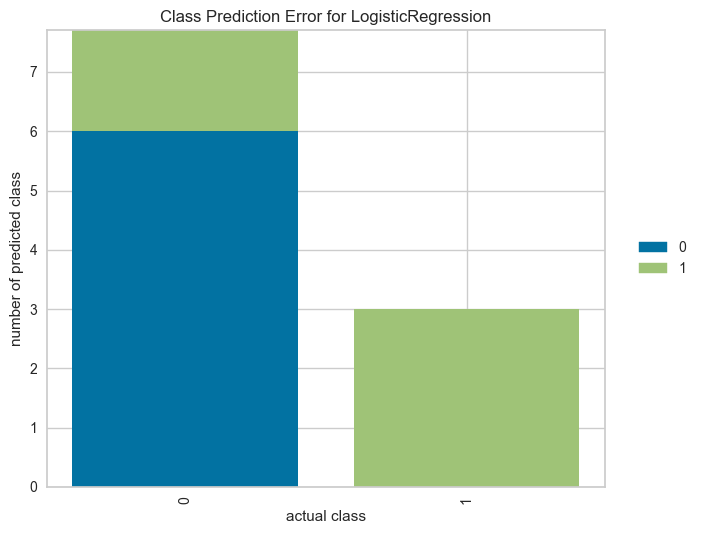

In [27]:
c.plot_model(tuned_class, 'error', save=path)
c.plot_model(tuned_class, 'error')

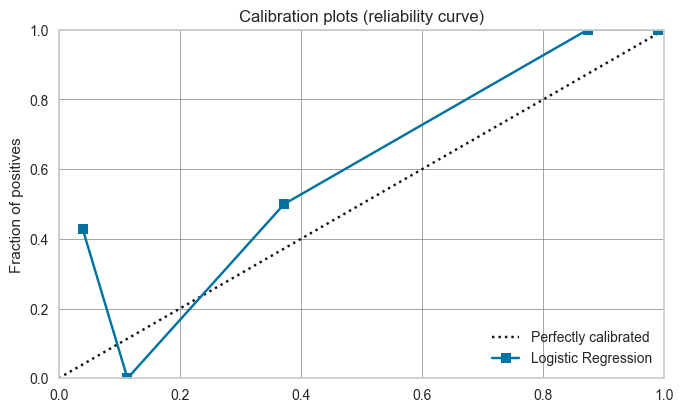

In [28]:
c.plot_model(tuned_class, 'calibration', save=path)
c.plot_model(tuned_class, 'calibration')

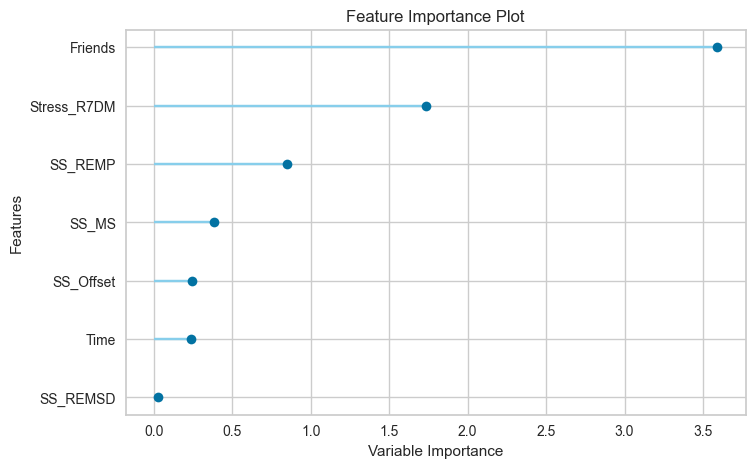

In [29]:
c.plot_model(tuned_class, 'feature', save=path)
c.plot_model(tuned_class, 'feature')